In [1]:
# line plot of corr(pred rating, true rating) across hold out percentages for subsampled data 
# run on full model, ratings-only model, and reports-only model 
# with semi-synthetic data for types with observed ratings
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
plt.rcParams['font.family'] = 'serif'

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
type_rating_observed_base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_type_rating_observed_base.csv'
results_dir = '/share/garg/311_data/sb2377/results'

# user specified arguments
types = {'Rodent': 'RodentDOHMH'}
holdout_pcts = {'100':100,
                '500':500,
                '1k':1000,
                '10k':10000,
                '100k':100000,
                'full':1000000}
models = {'Full model': {'Rodent':{'100':{'job_ids':[10 * i + 6700 for i in range(13)]},
                                   '500':{'job_ids':[10 * i + 6702 for i in range(13)]},
                                   '1k':{'job_ids':[10 * i + 6704 for i in range(13)]},
                                   '10k':{'job_ids':[10 * i + 6706 for i in range(13)]},
                                   '100k':{'job_ids':[10 * i + 6708 for i in range(13)]},
                                   'full':{'job_ids':[3000] + [i * 3 + 3005 for i in range(12)]}}},
          'Ratings-only model': {'Rodent':{'100':{'job_ids':[10 * i + 6701 for i in range(13)]},
                                           '500':{'job_ids':[10 * i + 6703 for i in range(13)]},
                                           '1k':{'job_ids':[10 * i + 6705 for i in range(13)]},
                                           '10k':{'job_ids':[10 * i + 6707 for i in range(13)]},
                                           '100k':{'job_ids':[10 * i + 6709 for i in range(13)]},
                                           'full':{'job_ids':[3002] + [i * 3 + 3007 for i in range(12)]}}}}
epoch = '59'

# plotting parameters
figsize=(3.25, 1)
save_path = "/home/sb2377/gnn_crowdsourced_model/figures/real_ratings_subsampled.pdf"

In [3]:
# load files
base_df = pd.read_csv(base_file)
type_rating_observed_base_df = pd.read_csv(type_rating_observed_base_file)

In [4]:
# get type indices
# for df with all types
type_df = base_df[['typeagency', 'type_idxs']].drop_duplicates()
indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    indices[type_name] = idx

# for df with only types with observed ratings
type_df = type_rating_observed_base_df[['typeagency', 'type_idxs']].drop_duplicates()
type_rating_observed_indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    type_rating_observed_indices[type_name] = idx

In [5]:
# get predicted ratings for all jobs
checkpoint_file = '{}/job{}/model-epoch={}.ckpt'
results_file = '{}/job{}/epoch={}_test.pkl'
checkpoint_counters = {}
results_counters = {}
for m in models:
    checkpoint_counters[m] = {}
    results_counters[m] = {}
    for t in types:
        checkpoint_counters[m][t] = 0
        results_counters[m][t] = 0
dfs = {}
for m in models:
    dfs[m] = {}
    for t in types:
        dfs[m][t] = {}
        for hold_out_pct in holdout_pcts:
            dfs[m][t][hold_out_pct] = []

for m in models:
    for t in types:
        for hold_out_pct in holdout_pcts:
            for job_idx in models[m][t][hold_out_pct]['job_ids']:
                if os.path.exists(checkpoint_file.format(results_dir, job_idx, epoch)):
                    checkpoint_counters[m][t] += 1
                if os.path.exists(results_file.format(results_dir, job_idx, epoch)):
                    results_counters[m][t] += 1
                    with open(results_file.format(results_dir, job_idx, epoch), 'rb') as file:
                        pred_rating, true_rating, mask, node_embedding, type_embedding, node_idxs, type_idxs, demographics, pred_pt, true_t = pickle.load(file)
                    
                    df = pd.DataFrame()
                    df['pred_rating'] = pred_rating
                    df['true_rating'] = true_rating
                    df['node_idxs'] = node_idxs
                    df['type_idxs'] = type_idxs
                    df['pred_pt'] = pred_pt
                    df['true_t'] = true_t
                    df['mask'] = mask
                    if m == 'Full model':
                        type_df = df[df['type_idxs'] == indices[t]]
                    else:
                        type_df = df[df['type_idxs'] == type_rating_observed_indices[t]]

                    dfs[m][t][hold_out_pct].append(type_df)
                else:
                    dfs[m][t][hold_out_pct].append([])

for m in models:
    for t in types:
        print('{} {}: checkpoint files done = {}'.format(m, t, checkpoint_counters[m][t]))
        print('{} {}: results files done = {}'.format(m, t, results_counters[m][t]))

Full model Rodent: checkpoint files done = 78
Full model Rodent: results files done = 78
Ratings-only model Rodent: checkpoint files done = 78
Ratings-only model Rodent: results files done = 78


Full model [0.3741934  0.34536631 0.34921905 0.39666846 0.58159832 0.67514337]
Ratings-only model [0.02087807 0.01670362 0.0092846  0.17195738 0.205227   0.63172471]


/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_121802/191567184.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


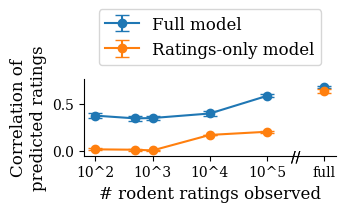

In [6]:
# plot figure
fig, ax = plt.subplots(len(types), 1, figsize=figsize)

# first get correlations for all models, types, and hold out percentages
corrs = {}
for m in models:
    corrs[m] = {}
    for t in types:
        corrs[m][t] = {}
        for hold_out_pct in holdout_pcts:
            corrs[m][t][hold_out_pct] = []
            for observed_df in dfs[m][t][hold_out_pct]:
                if len(observed_df) > 0:
                    # Filter and group the data
                    if m == 'Full model':
                        observed_test_type_df = observed_df[observed_df['type_idxs'] == indices[t]]
                    else:
                        observed_test_type_df = observed_df[observed_df['type_idxs'] == type_rating_observed_indices[t]]
                    node_df = observed_test_type_df.groupby(['node_idxs', 'type_idxs']).mean().reset_index()
                    corr = pearsonr(node_df['pred_rating'], node_df['true_rating'])[0]
                    corrs[m][t][hold_out_pct].append(corr)
                else:
                    corrs[m][t][hold_out_pct].append(np.nan)

# pre process mean and stderr across hold out percentages for each model x type pair
plot_values = {}
for m in models:
    plot_values[m] = {}
    for t in types:
        corr_set = np.array([corrs[m][t][hold_out_pct] for hold_out_pct in holdout_pcts])
        corr_set_mean = np.nanmean(corr_set, axis=1)
        corr_set_stderr = 1.96 * np.nanstd(corr_set, axis=1) / (np.count_nonzero(~np.isnan(corr_set), axis=1) - 1)
        plot_values[m][t] = {'mean': corr_set_mean, 'stderr': corr_set_stderr}
        print(m, corr_set_mean)

# make line plot
for i, m in enumerate(models):
    for j, t in enumerate(types):
        plt.errorbar(np.log10(np.array(list((holdout_pcts.values()))))[:-1], np.array(plot_values[m][t]['mean'])[:-1], yerr=plot_values[m][t]['stderr'][:-1], fmt='-o', capsize=5, color='C{}'.format(i), label=m)
        plt.errorbar(np.log10(np.array(list((holdout_pcts.values()))))[-1:], np.array(plot_values[m][t]['mean'])[-1:], yerr=plot_values[m][t]['stderr'][-1:], fmt='-o', capsize=5, color='C{}'.format(i))
        plt.ylim([min(plot_values['Ratings-only model'][t]['mean'] - plot_values['Ratings-only model'][t]['stderr']) - 0.05, 
                        max(plot_values['Full model'][t]['mean'] - plot_values['Full model'][t]['stderr']) + 0.1])  # Adjust margins
        plt.xticks([2, 3, 4, 5, 6], ['10^2', '10^3', '10^4', '10^5', 'full'])
        plt.text(5.5, 0.02, '//', ha='center', va='top', fontsize=10)
            
        plt.ylabel('Correlation of\npredicted ratings', fontsize=12)
    
sns.despine()

plt.xlabel('# rodent ratings observed', fontsize=12)
plt.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 1.07))

# Show plot
plt.tight_layout()
plt.savefig(save_path, format="pdf", bbox_inches="tight")

In [7]:
plot_values

{'Full model': {'Rodent': {'mean': array([0.3741934 , 0.34536631, 0.34921905, 0.39666846, 0.58159832,
          0.67514337]),
   'stderr': array([0.02580139, 0.02580653, 0.02468797, 0.02471577, 0.01535042,
          0.0138906 ])}},
 'Ratings-only model': {'Rodent': {'mean': array([0.02087807, 0.01670362, 0.0092846 , 0.17195738, 0.205227  ,
          0.63172471]),
   'stderr': array([0.01134471, 0.00940548, 0.00538591, 0.00363989, 0.01117603,
          0.0166332 ])}}}

In [9]:
for m in models.keys():
    corrs = plot_values[m]['Rodent']['mean']
    corrs = np.array(corrs)
    print(m, corrs.mean())

Full model 0.45369815050241996
Ratings-only model 0.17596256418952758
